In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## This notebook trains and assesses the random forest classifier. Model performance is visualized using the classification report (Fig. 6) and a confusion matrix (Fig. 7). Features importances are also plotted (Fig. 8). 

#### EML_May_2012_2021.csv contains 10 years (2012-2021) of EML data for the month of May only. Data are 6-hourly (0, 6, 12, 18 UTC).
 - 'eml' variable is binary, where 1=EML, 0=no EML. This is the variable we are trying to predict.
 - latitude, longitude, and time variables indicate when and where there is or isn't an EML.
 - all other variables are possible predictors for our ML model

In [2]:
# Open the CSV file containing the May 2012-2021 EML dataset
df = pd.read_csv('/home/scratch/mandrews/eae_598/EML_May_2012_2021.csv')
df.head()

,latitude,longitude,time,Z500,t500,wspd500,wdir500,mucape,mucin,mlcape,...,theta_850,theta_925,theta_sfc,t925,rh_sfc,rh_925,rh_850,rh_700,rh_500,rh_3_6km
0,26.0,253.00,2012-05-01 00:00:00,5.843171,-9.134342,5.660553,205.892493,0.0,0.0,0.0,...,NaN,NaN,313.883362,NaN,0.267810,NaN,NaN,0.448221,0.275484,0.199151
1,26.0,253.25,2012-05-01 00:00:00,5.843966,-9.297320,5.074431,202.685653,0.0,0.0,0.0,...,NaN,NaN,315.494537,NaN,0.253985,NaN,NaN,0.365675,0.325275,0.236668
2,26.0,253.50,2012-05-01 00:00:00,5.844372,-9.441615,5.426132,192.996072,0.0,0.0,0.0,...,NaN,NaN,316.565155,NaN,0.233949,NaN,NaN,0.309428,0.276469,0.241000
3,26.0,253.75,2012-05-01 00:00:00,5.846489,-9.879836,4.917766,180.679988,0.0,0.0,0.0,...,NaN,NaN,317.429565,NaN,0.219240,NaN,NaN,0.280152,0.366142,0.259380
4,26.0,254.00,2012-05-01 00:00:00,5.847194,-10.555432,3.565028,182.630536,0.0,0.0,0.0,...,NaN,NaN,318.495514,NaN,0.158403,NaN,NaN,0.231137,0.591805,0.389781


In [3]:
# This seperates the date column to get a new year column
df['year'] = [int(x.split('-')[0]) for x in df['time']]

# This seperates the date column to get a new hour column
df['hour'] = [str(x.split(' ')[1])[0:2] for x in df['time']]

# Change variable types to integers to make plotting easier
df['eml'] = df['eml'].astype(int)
df['hour'] = df['hour'].astype(int)

In [4]:
# Show names of all columns in the dataset
print(df.columns)

Index(['latitude', 'longitude', 'time', 'Z500', 't500', 'wspd500', 'wdir500',
       'mucape', 'mucin', 'mlcape', 'mlcin', 'sbcape', 'sbcin', 'Z700', 't700',
       'Z850', 't850', 'td850', 'wspd850', 'wdir850', 't_sfc', 'td_sfc',
       'q_sfc', 'z_sfc', 'u_sfc', 'v_sfc', 't_max', 'lr75', 'lr25', 'bs06',
       'srh01', 'srh03', 'p_sfc', 'lid_strength', 'eml', 'lr03', 'lr01',
       'lr85', 'theta_500', 'theta_700', 'theta_850', 'theta_925', 'theta_sfc',
       't925', 'rh_sfc', 'rh_925', 'rh_850', 'rh_700', 'rh_500', 'rh_3_6km',
       'year', 'hour'],
      dtype='object')


## Setting up the machine learning subsets. 
The dataset is divided into a testing (20%), training (70%), and validation (10%) subsets by year. Data was divided this way because of x, y, z...

In [5]:
# Prior to dividing the dataset, nans in the dataset are filled with zeros because scikit-learn's Random Forest Classifier cannot handle nan values
# nan values occur primarily in the high terrain for variables at 850/925-mb, where these levels are below the surface
df = df.fillna(0, inplace=False)

In [6]:
# Training dataset is the first 7 years of May data; 2012-2018
df_train = df[df['year'] <= 2018]

# Validation dataset is 1 year of May data; 2019
df_val = df[(df['year'] >= 2019) & (df['year'] < 2020)]

# Testing dataset consists of 2 years of May data; 2020-2021
df_test = df[(df['year'] >= 2020)]

In [7]:
# Show the number of EML (1) and non EML (0) cases in the training subset
df_train.eml.value_counts()

0    6425350
1     113294
Name: eml, dtype: int64

In [8]:
# Show the number of EML (1) and non EML (0) cases in the validation subset
df_val.eml.value_counts()

0    926351
1      7741
Name: eml, dtype: int64

In [9]:
# Show the number of EML (1) and non EML (0) cases in the testing subset
df_test.eml.value_counts()

0    1845773
1      22411
Name: eml, dtype: int64

### Training a random forest classifier. 
Random forest classifiers were trained using the training subset. Eleven model configurations were assessed using the validation subset (only the best performing configuration is shown here). The best performing model configuration, defined by having high accuracy and the best balance between precision and recall was selected. Next, the generalizability of this model was assessing using the testing subset. Feature importance was also calculated to highlight the features most important to the model. 

In [10]:
# All features (49) input into the random forest classifier
feature_list = ['latitude', 'longitude', 'Z500', 't500', 'wspd500', 'wdir500','mucape', 'mucin', 'mlcape', 'mlcin', 
        'sbcape', 'sbcin', 'Z700', 't700','Z850', 't850', 'td850', 'wspd850', 'wdir850', 't_sfc', 'td_sfc','q_sfc', 
        'z_sfc', 'u_sfc', 'v_sfc', 't_max', 'lr75', 'lr25', 'bs06','srh01', 'srh03', 'p_sfc', 'lid_strength', 
        'lr03', 'lr01','lr85', 'theta_500', 'theta_700', 'theta_850', 'theta_925', 'theta_sfc','t925', 'rh_sfc', 
        'rh_925', 'rh_850', 'rh_700', 'rh_500', 'rh_3_6km', 'hour']

#### Model configuration # 11: n_estimators=100, class_weight='balanced_subsample', min_samples_split=5

In [31]:
# Create an untrained random forest classifier
rf_clf_11 = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', min_samples_split=5, max_depth=20, random_state=1830295)

# Train the random forest classifier using the training subset for the specified columns (feature_list) and the labels (binary eml column)
rf_clf_11.fit(df_train[feature_list].values, df_train.eml.values)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       min_samples_split=5, random_state=1830295)

In [32]:
# Now evaluate the 11th model configuration using the validation dataset

# Pass the validation data columns into the predict function
predicted_11 = rf_clf_11.predict(df_val[feature_list].values)

# Set the expected labels to the EML variable
expected_11 = df_val.eml.values

# Print the classification report for model configuration #11 (for validation subset)
print("Classification report for classifier %s:\n%s\n"
      % (rf_clf_11, metrics.classification_report(expected_11, predicted_11)))

Classification report for classifier RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       min_samples_split=5, random_state=1830295):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    926351
           1       0.33      0.76      0.46      7741

    accuracy                           0.99    934092
   macro avg       0.66      0.87      0.72    934092
weighted avg       0.99      0.99      0.99    934092




In [34]:
# Next, test the generalizability of the classifier using the TESTING dataset and calculate performance metrics

# Pass the testing data columns into the predict function
predicted = rf_clf_11.predict(df_test[feature_list].values)

# Set the expected labels to the EML variable
expected = df_test.eml.values

# Print the classification report (for testing subset)
print("Classification report for classifier %s:\n%s\n"
      % (rf_clf_11, metrics.classification_report(expected, predicted)))

Classification report for classifier RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       min_samples_split=5, random_state=1830295):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1845773
           1       0.35      0.86      0.49     22411

    accuracy                           0.98   1868184
   macro avg       0.67      0.92      0.74   1868184
weighted avg       0.99      0.98      0.98   1868184




In [35]:
# Get the confusion matrix
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Confusion matrix:
[[1809529   36244]
 [   3204   19207]]


In [38]:
# Calculate variable importance

# Extract feature importance from the trained model
feature_importance = rf_clf_11.feature_importances_

# Create dataframe from feature list and importance
importance_df = pd.DataFrame({
    'Feature': feature_list,
    'Importance': feature_importance})

# Sort by order of highest importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print features by importance
importance_df

,Feature,Importance
27,lr25,0.205840
26,lr75,0.175793
7,mucin,0.083611
13,t700,0.066871
11,sbcin,0.042418
6,mucape,0.041689
37,theta_700,0.041558
9,mlcin,0.039094
45,rh_700,0.032604
35,lr85,0.028450


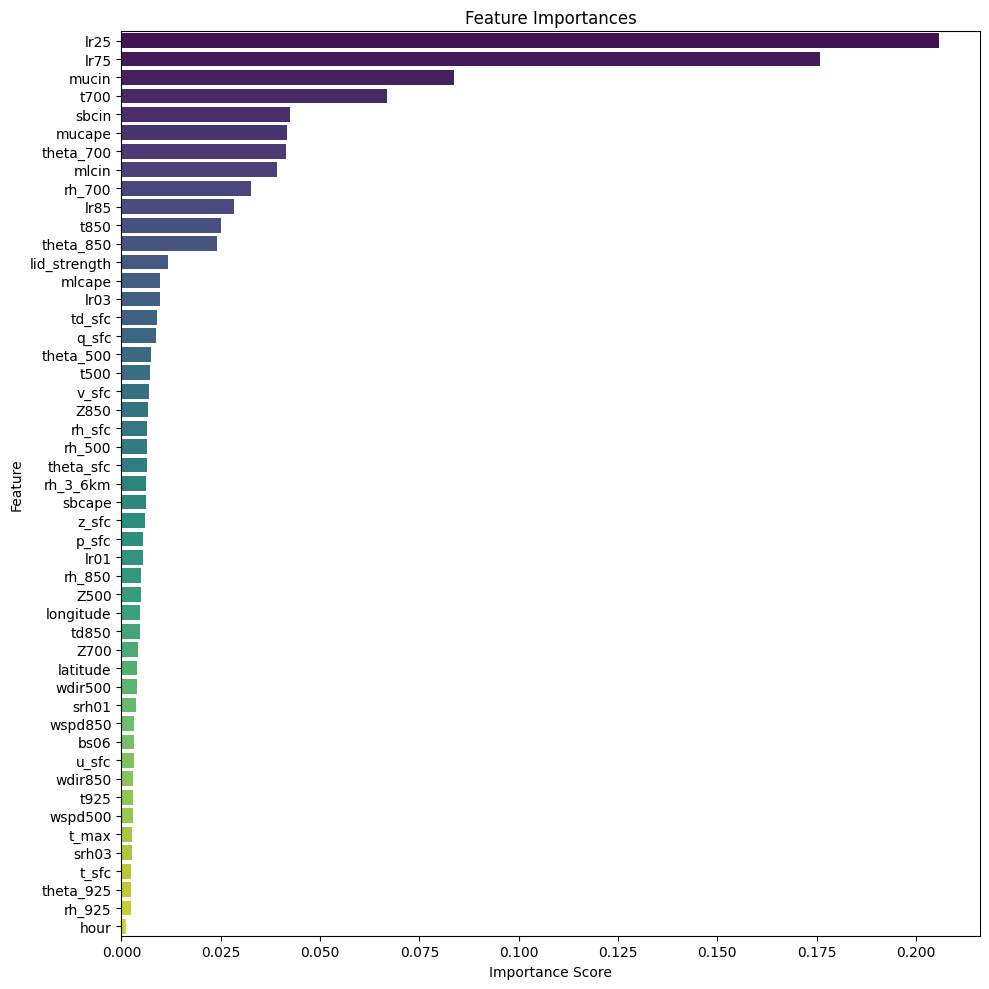

In [40]:
# Plot feature importances in order of most to least important
plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

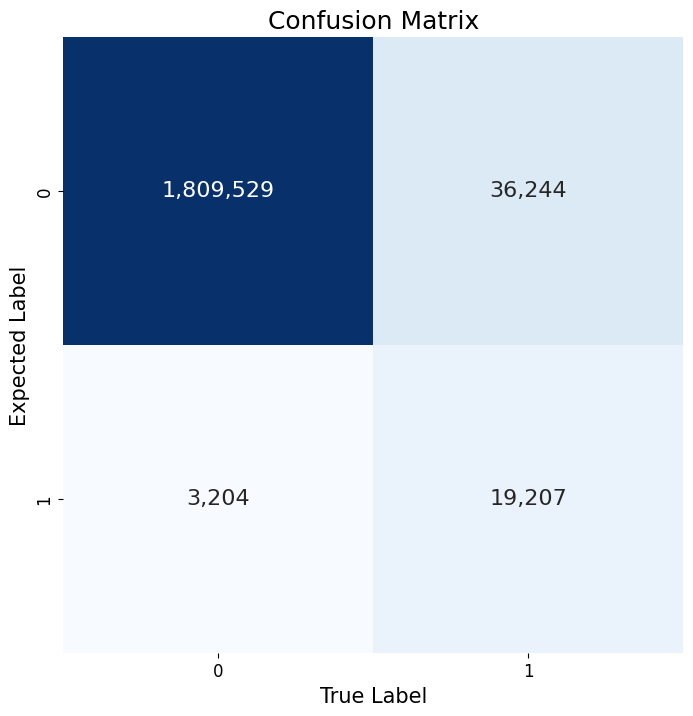

In [47]:
# Plot the confusion matrix
cf_matrix = np.array([[1809529, 36244],
                      [3204, 19207]])

plt.figure(figsize=(8,8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False, fmt=',d', annot_kws={"size": 16}, vmax=0.25e6)
ax.set_xlabel("True Label", fontsize=15)
ax.set_ylabel("Expected Label", fontsize=15)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.set_title('Confusion Matrix', fontsize=18)
plt.show()